In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim import models, corpora
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
bios = pd.read_csv('playlist.csv', index_col=0)
bios.set_index('track_name', inplace=True)
bios = bios['biographies'][bios['love']==1]
bios = bios.apply(lambda x: unicode(x, errors='ignore'))
bios = list(set(bios))
bios[:3]


[u'[This is the world of The Knife: precise, particular, dark, ..., There are multiple artists with the name The Knife:  1) Electronic duo from Stockholm, Sweden. 2) Spanish symphonic prog band  1) The Knife was an electronic duo from Stockholm, Sweden formed in 1999. The band consisted of siblings Karin Dreijer Andersson (formerly of Honey is Cool, now Fever Ray) and Olof Dreijer - who also run their own record company, Rabid Records.  The group rarely made public appearances, most of their promotional photos featured the members wearing masks, and formerly refused to perform live concerts. However the group has showed themselves in public wearing masks formed as bird\'s beaks, similar to those used by medieval doctors.  The Knife won a Swedish Grammy award for best pop group of the year 2003, but they boycotted the ceremony by sending two representatives of another artist group dressed as gorillas with the number 50 written on their costumes, apparently as a protest against male domi

###Tokenize:

In [4]:
#not doing tfidf because I think it screws up the LDA
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: (
                english_stemmer.stem(w) for w in analyzer(doc))
    
    def build_tokenizer(self):
        tokenizer =  super(CountVectorizer, self).build_tokenizer()
        return lambda word: [
                english_stemmer.stem(w) for w in tokenizer(word)]
    
vectorizer = StemmedVectorizer(min_df=1,
                stop_words='english', decode_error='ignore')
X = vectorizer.fit_transform(bios)

num_samples, num_features = X.shape
corpus =  gensim.matutils.Sparse2Corpus(X)
print "#samples: %d, #features: %d"% (num_samples, num_features)
print corpus

#samples: 35, #features: 9472


In [5]:
tokenize = vectorizer.build_tokenizer()
tokens = [tokenize(bio) for bio in bios]
dictionary = corpora.Dictionary(tokens)
print dictionary.items()[:10]

[(2142, u'mellotron'), (2983, u'woodi'), (1191, u'yellow'), (529, u'four'), (4472, u'francesco'), (9278, u'honorari'), (6672, u'bearsvill'), (2163, u'authoris'), (4512, u'battisti'), (6829, u'lorn')]


In [6]:
model = models.ldamodel.LdaModel(
    corpus=corpus,
    num_topics=100,
    id2word=dictionary,
    alpha=1,
    passes=3)

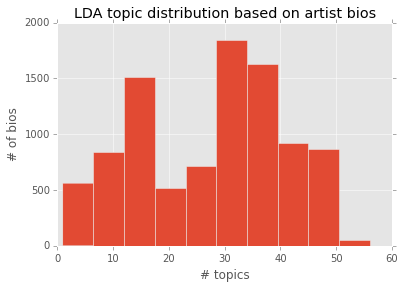

In [7]:
plt.style.use('ggplot')
num_topics_used = [len(model[doc]) for doc in corpus]
plt.hist(num_topics_used)
ax = plt.gca()
ax.set_title('LDA topic distribution based on artist bios')
ax.set_xlabel('# topics')
ax.set_ylabel('# of bios')

In [8]:
topic_list = []
for topic,_ in model.top_topics(corpus):
    _, to_show = zip(*topic)
    topic_string = " ".join(list(to_show))
    topic_list.append(topic_string)
    print topic_string
    print

articl magic appar follow planningtorock speci protest repres song voic muffl did daze michael send soni gorilla celebr under kate

appar planningtorock song did articl voic soni send speci horn daze magic michael under repres muffl kate gorilla celebr protest

did appar send planningtorock song soni michael repres daze speci voic horn magic articl celebr follow veri kate bravia cool

planningtorock appar did song articl soni daze under magic voic send speci repres follow veri michael celebr all horn kate

planningtorock appar articl did song send speci soni follow daze repres magic kate michael voic protest under electron all horn

planningtorock veri appar song did articl daze michael voic horn soni electron speci celebr send repres follow cool kate magic

soni planningtorock appar song daze send did speci articl voic celebr repres horn michael kate sent cool lynch follow magic

appar song planningtorock did voic daze michael articl repres speci soni send kate follow horn magic under

In [11]:
top = model.top_topics(corpus)[0][0]
top = [(w, int(v*1000.)) for v,w in top]
top[:5]

[(u'articl', 388),
 (u'magic', 48),
 (u'appar', 38),
 (u'follow', 30),
 (u'planningtorock', 30)]

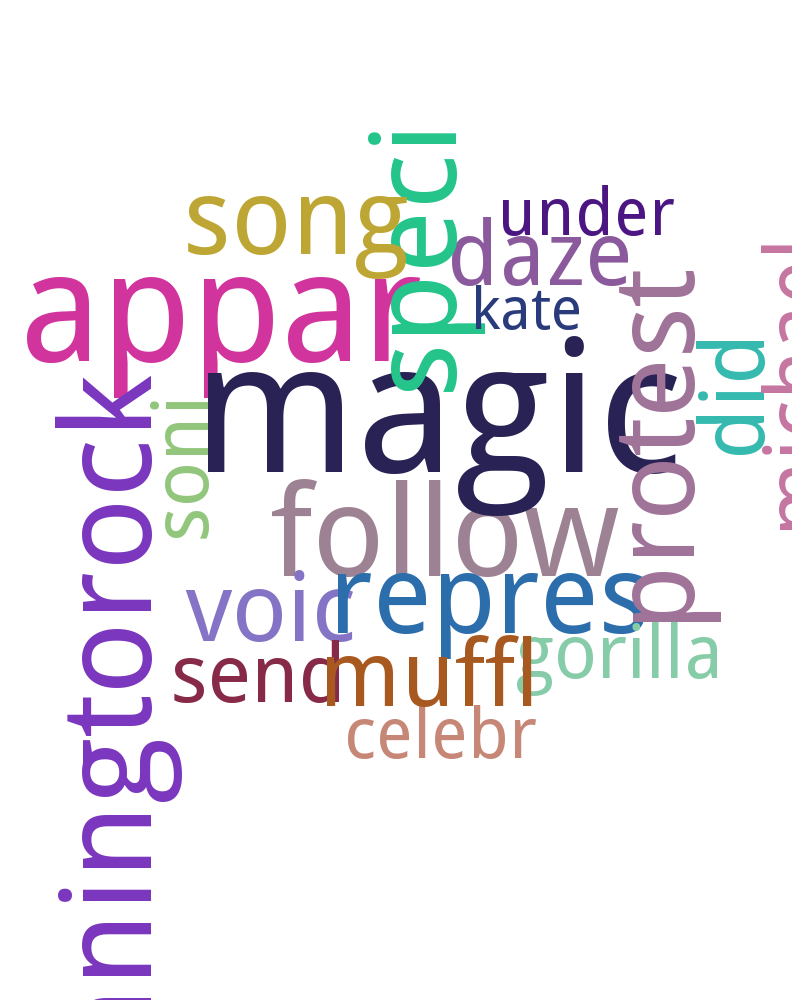

In [24]:
from pytagcloud import create_tag_image, make_tags
tags = make_tags(top[1:50], maxsize=150)
create_tag_image(tags, 'tag_cloud.png',
                size=(1000,1000))
from IPython.display import Image
Image(filename='tag_cloud.png') 

In [27]:
top2 = model.top_topics(corpus)[1][0]
top2 = [(w, int(v*1000.)) for v,w in top2]
print top2[:5]

[(u'appar', 194), (u'planningtorock', 77), (u'song', 67), (u'did', 57), (u'articl', 42)]


[(u'appar', 194), (u'planningtorock', 77), (u'song', 67), (u'did', 57), (u'articl', 42)]


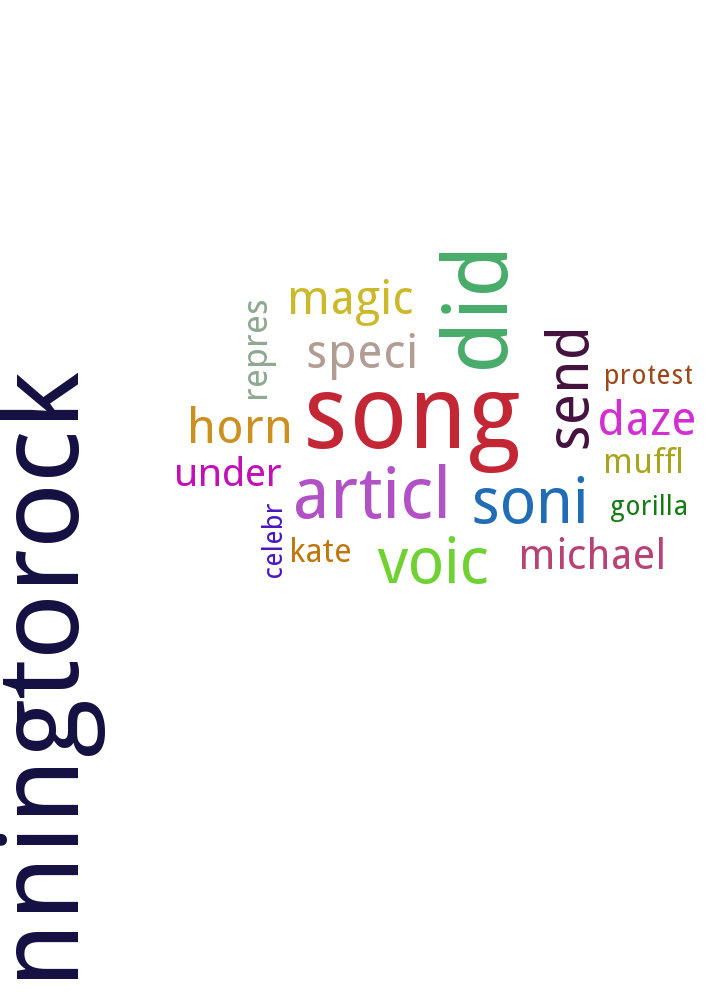

In [30]:
from pytagcloud import create_tag_image, make_tags

top2 = model.top_topics(corpus)[1][0]
top2 = [(w, int(v*1000.)) for v,w in top2]
print top2[:5]
tags = make_tags(top2[1:50], maxsize=100)
create_tag_image(tags, 'tag_cloud2.png',
                size=(1000,1000))
from IPython.display import Image
Image(filename='tag_cloud2.png') 

In [ ]:
# to find closest...
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(topics))
largest = pairwise.max()
for ti in range(len(topics)):
    pairwise[ti, ti] = largest+1

def closest_to(topic_id):
    return pairwise[topic_id].argmin()


print topic_list[2:3]
print
print topic_list[closest_to([8,2])]
